*Compiled by Carlos Mesquita, Lize-Alet Morkel, and Frank Patracuolla*

# Process 3A

![Process 3 Diagram](../images/process-3.png)

# Imports

In [20]:
### Imports
import pandas as pd
import numpy as np

### Seaborn for visualizations
import matplotlib.pyplot as plt
import seaborn as sns

### Scikit-Learn for imputation and other transformations
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

### Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

### Used for feature selection
#### Correlation method - for classification chi2 only
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
#### RFE method - replace the model with the model you plan to use
from sklearn.feature_selection import RFE
#### this method can be used for both topK and cut-off
from sklearn.linear_model import Ridge
#### specifically tree-based feature importance method
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
#### for voting
from collections import Counter
#### for ANOVA
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Data Dictionary
| Variable | Variable Name | Variable Definition | Data Type | Allowed Values |
| --- | --- | --- | --- | --- |
| Y1 | Pre-IPO Price | Revision Set to 1 if P(IPO) < P(mid), where P(mid) = (P(H)+P(L))/2, otherwise 0 | Binary/Boolean | 0 or 1 |
| Y2 | Post-IPO Initial Return | Set to 1 if P(IPO) < P(1Day), otherwise 0 | Binary/Boolean | 0 or 1 |
| eps_dummy | Positive EPS Dummy | Dummy variable set to 1 if C3 is positive at the time of the IPO, otherwise 0 | Binary/Boolean | 0 or 1 |
| overhang | Share Overhang | C5’ = C5/C6 | Continuous/Float | number between 0 - 1 |
| up_revision | Up Revision | Set to (P(IPO) – P(mid))/P(mid) x 100%, if P(IPO) > P(mid), otherwise 0 | Continuous/Float | any real number |
| P(mid) | Average Price | P(mid) = (P(H)+P(L))/2 | Continuous/Float | positive number |
| long_s/total_s | Long Sentences vs Total Sentences | Ratio of long sentences out of total sentences | Continuous/Float | positive number |
| real_w/total_w | Real Words vs Total Words | Ratio of real words out of total words  | Continuous/Float | positive number |
| long_w/real_w | Long words vs Real Words | Ratio of long words out of real words | Continuous/Float | positive number |
| positive_w/real_w | Positive Words vs Real Words | Ratio of positive words out of real words | Continuous/Float | positive number |
| negative_w/real_w | Negative Words vs Real Words | Ratio of negative words out of real words | Continuous/Float | positive number |
| uncertain_w/real_w | Uncertain Words vs Real Words | Ratio of uncertain words out of real words | Continuous/Float | positive number |
| sic_tech-non_tech | Tech / Non-Tech | Set to 1 if the company's SIC code is considered tech and 0 if it is other | Binary | 0 or 1 |
| sic_mfg | SIC Manufacturing | Set to 1 if the company's SIC code is considered manufacturing and 0 if it is not manufacturing | Binary | 0 or 1 |
| sic_svc | SIC Services | Set to 1 if the company's SIC code is considered services and 0 if it is not services | Binary | 0 or 1 |
| sic_other | SIC Other | Set to 1 if the company's SIC code is considered other and 0 if it is not other | Binary | 0 or 1 |

# Read Data

In [21]:
### Read in data
path = "data\Competition1_raw_data.xlsx"
df = pd.read_excel(path, na_values=["-"])

# Filter Important Features

We first filter out I1 and I2 as they were determined to be non-important features for our analysis.

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 682 entries, 0 to 681
Data columns (total 22 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   I1       682 non-null    object 
 1   I2       682 non-null    object 
 2   I3       674 non-null    object 
 3   P(IPO)   677 non-null    float64
 4   P(H)     672 non-null    float64
 5   P(L)     672 non-null    float64
 6   P(1Day)  660 non-null    float64
 7   C1       660 non-null    float64
 8   C2       660 non-null    float64
 9   C3       646 non-null    float64
 10  C4       660 non-null    float64
 11  C5       676 non-null    float64
 12  C6       676 non-null    float64
 13  C7       610 non-null    float64
 14  T1       681 non-null    float64
 15  T2       681 non-null    float64
 16  T3       681 non-null    float64
 17  T4       681 non-null    float64
 18  T5       681 non-null    float64
 19  S1       681 non-null    float64
 20  S2       681 non-null    float64
 21  S3       681 non

In [23]:
### Filter features we will be focusing on
df1 = df.iloc[:, 2:]
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 682 entries, 0 to 681
Data columns (total 20 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   I3       674 non-null    object 
 1   P(IPO)   677 non-null    float64
 2   P(H)     672 non-null    float64
 3   P(L)     672 non-null    float64
 4   P(1Day)  660 non-null    float64
 5   C1       660 non-null    float64
 6   C2       660 non-null    float64
 7   C3       646 non-null    float64
 8   C4       660 non-null    float64
 9   C5       676 non-null    float64
 10  C6       676 non-null    float64
 11  C7       610 non-null    float64
 12  T1       681 non-null    float64
 13  T2       681 non-null    float64
 14  T3       681 non-null    float64
 15  T4       681 non-null    float64
 16  T5       681 non-null    float64
 17  S1       681 non-null    float64
 18  S2       681 non-null    float64
 19  S3       681 non-null    float64
dtypes: float64(19), object(1)
memory usage: 106.7+ KB


# Validate Data

Next, we validated the data to ensure all the values were in the allowed range for that feature. Features were separated into three validations, values that must be binary (0 or 1), values that could be non-negative (anything greater than or equal to 0), or values that must be positive (greater than 0). We came to the conclusion that C2 (Top-tier Dummy) should be binary, C7 (Sales) can be 0 because of the medical companies, and everything else should have a positive value.

P(IPO), P(H), P(L), and P(1Day) will be addressed in the next step.

In [24]:
def validate_data(col, test):
    if test == "non-negative":
        return np.where(col >= 0, col, np.nan)
    elif test == "positive":
        return np.where(col > 0, col, np.nan)
    elif test == "binary":
        return np.where((col == 0) | (col == 1), col, np.nan)

### Add columns to check to each of the lists
### C3 & C4 must be a number
### P(IPO), P(H), P(L), P(1Day) causing errors
check_binary = ['C2']
check_non_negative = ['C7']
check_positive = ['C1', 'C5', 'C6', 'T1', 'T2', 'T3', 'T4', 'T5', 'S1', 'S2', 'S3']

### Run non-negative check on columns
for col in check_non_negative:
    df1[col] = df1[col].apply(validate_data, test="non-negative")
### Run positive check on columns
for col in check_positive:
    df1[col] = df1[col].apply(validate_data, test="positive")
## run binary check on columns
for col in check_binary:
    df1[col] = df1[col].apply(validate_data, test="binary")

df2 = df1.copy()

# Fix Missing Values

In order to handle missing values in the dataset, we decided to drop some rows and then use interpolation on the remaining missing values. First we did an initial exploration of the ration of missing values in the dataset.  

Shape Before: (682, 20)


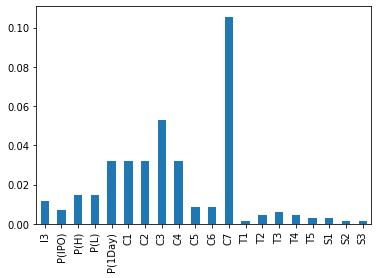

In [25]:
print("Shape Before:", df2.shape)
df2.isna().mean().plot(kind="bar");

We determined to handle the missing values in the P-features by dropping the rows that contained missing values in any of these columns. We then imputed any remaining missing data with the median. We used the median because we are assuming that this will have less impact on the distribution of the data.

In [26]:
def fix_missing(df):
    df = df.dropna(subset=['P(IPO)', 'P(H)', 'P(L)', 'P(1Day)']).reset_index(drop=True)

    df_cat = df.iloc[:, :1]
    df_cont = df.iloc[: , 1:]

    inames = list(df_cont.columns)
    imp_med = SimpleImputer(missing_values=np.nan, strategy='median')
    df_cont = pd.DataFrame(imp_med.fit_transform(df_cont), columns=inames)

    df = pd.concat([df_cat, df_cont], axis=1)
    return df

df2 = fix_missing(df2)

This accounted for all missing values and lowered the ratio of missing for all columns to 0 while only dropping 22 rows.

Shape After: (660, 20)


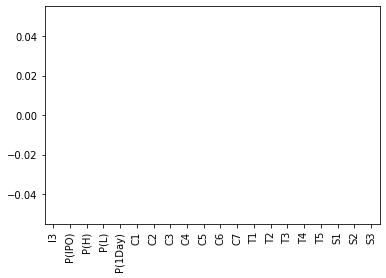

In [27]:
print("Shape After:", df2.shape)
df2.isna().mean().plot(kind="bar");

# Create Features

Now the fun begins. We created several new features, some as helpers to assist in later claculations, and others to be used in our prediction model.

In [28]:
def create_features(df):
    ### P(mid)
    df['P(mid)'] = (df['P(H)'] + df['P(L)']) / 2

    ### Pre-IPO Price Revision
    df['Y1'] = np.where(df['P(IPO)'] < df['P(mid)'], 1, 0) 

    ### Post-IPO initial Return
    df['Y2'] = np.where(df['P(IPO)'] < df['P(1Day)'], 1, 0) 

    ### Positive EPS Dummy
    df["eps_dummy"] = np.where(df['C3'] > 0, 1, 0)

    ### Share Overhang
    df["overhang"] = df['C5'] / df['C6']

    ### Up revision
    df["up_revision"] = np.where(df['P(IPO)'] > df['P(mid)'], ((df['P(IPO)'] - df['P(mid)']) / df['P(mid)']) * 100 , 0)

    ### Ratio of long sentences out of total sentences
    df["long_s/total_s"] = (df['T4']/ df['T1'])

    ### Ratio of real words out of total words 
    df["real_w/total_w"] = (df['T3']/ df['T2'])

    ### Ratio of long words out of real words
    df["long_w/real_w"] = (df['T5']/ df['T3'])

    ### Ratio of positive words out of real words
    df["positive_w/real_w"] = (df['S1']/ df['T3'])

    ### Ratio of negative words out of real words
    df["negative_w/real_w"] = (df['S2']/ df['T3'])

    ### Ratio of uncertain words out of real words
    df["uncertain_w/real_w"] = (df['S3']/ df['T3'])

    return df

df3 = create_features(df2)
df3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 660 entries, 0 to 659
Data columns (total 32 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   I3                  660 non-null    object 
 1   P(IPO)              660 non-null    float64
 2   P(H)                660 non-null    float64
 3   P(L)                660 non-null    float64
 4   P(1Day)             660 non-null    float64
 5   C1                  660 non-null    float64
 6   C2                  660 non-null    float64
 7   C3                  660 non-null    float64
 8   C4                  660 non-null    float64
 9   C5                  660 non-null    float64
 10  C6                  660 non-null    float64
 11  C7                  660 non-null    float64
 12  T1                  660 non-null    float64
 13  T2                  660 non-null    float64
 14  T3                  660 non-null    float64
 15  T4                  660 non-null    float64
 16  T5      

We decided to bin the SIC codes from column I3 in two ways. First, into two groups, tech or non-tech which is represented as a binary value: 1 for tech and 0 for non-tech. For companies with multiple SIC codes in the dataset, we chose to go with the first SIC code listed.

In [29]:
def bin_tech_nontech (col):
    ### Create a mask that checks if the first two characters of the value in the 'I3' column are equal to 73
    mask_73 = col.astype(str).str[:2] == "73"

    ### Create a mask that checks if the first two characters of the value in the 'I3' column are equal to 37
    mask_37 = col.astype(str).str[:2] == '37'

    ### Create a mask that checks if the first four characters of the value in the 'I3' column are equal to 3674
    mask_semiconductors = col.astype(str).str[:4] == '3674'

    ###This is creating a mask that checks if the first 3 nummbers are 506
    electrical_goods = col.astype(str).str[:3] == '506'

    ###This is creating a mask that checks if the first 4 nummbers are 3572
    comp_storage = col.astype(str).str[:4] == '3572'

    ### np.logicalor statement is just seeing if any are true and had to use a few because it only takes 3 argumenrs
    mask_tech = np.logical_or(mask_73, np.logical_or(mask_37, np.logical_or(mask_semiconductors, np.logical_or(electrical_goods, comp_storage))))
    ### Then we just put it into a quick np.where and this creates a tech/non-tech bin
    col = np.where(mask_tech, 1, 0)

    return col

df3['sic_tech-non_tech'] = bin_tech_nontech(df3['I3'])
df3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 660 entries, 0 to 659
Data columns (total 33 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   I3                  660 non-null    object 
 1   P(IPO)              660 non-null    float64
 2   P(H)                660 non-null    float64
 3   P(L)                660 non-null    float64
 4   P(1Day)             660 non-null    float64
 5   C1                  660 non-null    float64
 6   C2                  660 non-null    float64
 7   C3                  660 non-null    float64
 8   C4                  660 non-null    float64
 9   C5                  660 non-null    float64
 10  C6                  660 non-null    float64
 11  C7                  660 non-null    float64
 12  T1                  660 non-null    float64
 13  T2                  660 non-null    float64
 14  T3                  660 non-null    float64
 15  T4                  660 non-null    float64
 16  T5      

We also wanted to bin the SIC codes into manufacturing, service, or other. This was added to the dataset using one-hot encoding. Some rows had multiple SIC codes. For this, we used external finance knowledge to determine in which category the company would fit best.

In [30]:
def classify(code):
    if code >= 20 and code <= 39:
        return 'mfg'
    elif code >= 70 and code <= 89:
        return 'svc'
    else:
        return 'other'

def bin_mso(row):
    row = str(row)
    if len(row.split(", ")) == 1:
        pre = int(row[:2])
        code = classify(pre)
        return code
        ### Add logic here to count how many of each code there are
        ### use classify helper function
    else:
        return row

df3['sic_mso'] = df3['I3'].apply(bin_mso)

### Manual fixes for multiple SIC Codes
df3.loc[df3['sic_mso'] == '6794, 3861, 3663, 7819', 'sic_mso'] = 'svc'
df3.loc[df3['sic_mso'] == '3651, 6794, 7819', 'sic_mso'] = 'svc'
df3.loc[df3['sic_mso'] == '3663, 3861, 6794', 'sic_mso'] = 'other'
df3.loc[df3['sic_mso'] == '7389, 5063', 'sic_mso'] = 'mfg'

### OHE
dummy_df = pd.get_dummies(df3['sic_mso'], prefix='sic')
df3 = pd.concat([df3, dummy_df], axis=1)

In [31]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 660 entries, 0 to 659
Data columns (total 37 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   I3                  660 non-null    object 
 1   P(IPO)              660 non-null    float64
 2   P(H)                660 non-null    float64
 3   P(L)                660 non-null    float64
 4   P(1Day)             660 non-null    float64
 5   C1                  660 non-null    float64
 6   C2                  660 non-null    float64
 7   C3                  660 non-null    float64
 8   C4                  660 non-null    float64
 9   C5                  660 non-null    float64
 10  C6                  660 non-null    float64
 11  C7                  660 non-null    float64
 12  T1                  660 non-null    float64
 13  T2                  660 non-null    float64
 14  T3                  660 non-null    float64
 15  T4                  660 non-null    float64
 16  T5      

# Filter Features

We then filtered the dataset one more time to remove any features that were used to engineer the additional features we created.

In [32]:
df4 = df3.loc[:, ('up_revision', 'C1', 'C4', 'overhang', 'C7', 
                  'long_s/total_s', 'real_w/total_w', 'long_w/real_w', 
                  'positive_w/real_w', 'negative_w/real_w', 'uncertain_w/real_w',
                  'C2', "eps_dummy", "sic_tech-non_tech", 
                  'sic_mfg', 'sic_svc', 'sic_other',
                  'Y1', 'Y2')]
df4.dtypes

up_revision           float64
C1                    float64
C4                    float64
overhang              float64
C7                    float64
long_s/total_s        float64
real_w/total_w        float64
long_w/real_w         float64
positive_w/real_w     float64
negative_w/real_w     float64
uncertain_w/real_w    float64
C2                    float64
eps_dummy               int64
sic_tech-non_tech       int64
sic_mfg                 uint8
sic_svc                 uint8
sic_other               uint8
Y1                      int64
Y2                      int64
dtype: object

# EDA

We separated our dataset into continuous and categorical features for the exploratory data analysis and further transformations we would perform on the dataset.

In [33]:
df4.describe(include="all").T

,count,mean,std,min,25%,50%,75%,max
up_revision,660.0,5.404645,10.877569,0.000000,0.000000,0.000000,7.692308,100.000000
C1,660.0,149.728788,152.817467,10.000000,85.000000,107.000000,155.250000,2087.000000
C4,660.0,0.007282,0.033318,-0.162352,-0.013927,0.009125,0.031571,0.092896
overhang,660.0,4.417255,5.133537,0.283223,2.850622,3.731035,4.857904,99.787255
C7,660.0,470.631368,1587.801852,0.074000,41.458000,107.462000,300.764000,30683.000000
long_s/total_s,660.0,0.628496,0.069606,0.395480,0.580706,0.628861,0.674461,0.826347
real_w/total_w,660.0,0.895157,0.044090,0.669838,0.883417,0.897294,0.909693,1.579238
long_w/real_w,660.0,0.058355,0.007148,0.035738,0.053662,0.058163,0.062670,0.082675
positive_w/real_w,660.0,0.005940,0.001928,0.001896,0.004608,0.005641,0.006984,0.014453
negative_w/real_w,660.0,0.010118,0.003310,0.002454,0.007843,0.009549,0.011805,0.028048


In [34]:
### Continuous Features
df_cont = df4.iloc[:, :11]
print(df_cont.columns)

### Categorical Features
df_cat = df4.iloc[: , 11:]
print(df_cat.columns)

Index(['up_revision', 'C1', 'C4', 'overhang', 'C7', 'long_s/total_s',
       'real_w/total_w', 'long_w/real_w', 'positive_w/real_w',
       'negative_w/real_w', 'uncertain_w/real_w'],
      dtype='object')
Index(['C2', 'eps_dummy', 'sic_tech-non_tech', 'sic_mfg', 'sic_svc',
       'sic_other', 'Y1', 'Y2'],
      dtype='object')


## Continuous Features

We explored at how each continuous feature is distributed using descriptive statistics and box plots to visualize the central tendency and spread of each feature. 

In [35]:
df_cont.describe()

,up_revision,C1,C4,overhang,C7,long_s/total_s,real_w/total_w,long_w/real_w,positive_w/real_w,negative_w/real_w,uncertain_w/real_w
count,660.000000,660.000000,660.000000,660.000000,660.000000,660.000000,660.000000,660.000000,660.000000,660.000000,660.000000
mean,5.404645,149.728788,0.007282,4.417255,470.631368,0.628496,0.895157,0.058355,0.005940,0.010118,0.012855
std,10.877569,152.817467,0.033318,5.133537,1587.801852,0.069606,0.044090,0.007148,0.001928,0.003310,0.003074
min,0.000000,10.000000,-0.162352,0.283223,0.074000,0.395480,0.669838,0.035738,0.001896,0.002454,0.006215
25%,0.000000,85.000000,-0.013927,2.850622,41.458000,0.580706,0.883417,0.053662,0.004608,0.007843,0.010724
50%,0.000000,107.000000,0.009125,3.731035,107.462000,0.628861,0.897294,0.058163,0.005641,0.009549,0.012639
75%,7.692308,155.250000,0.031571,4.857904,300.764000,0.674461,0.909693,0.062670,0.006984,0.011805,0.014270
max,100.000000,2087.000000,0.092896,99.787255,30683.000000,0.826347,1.579238,0.082675,0.014453,0.028048,0.033235


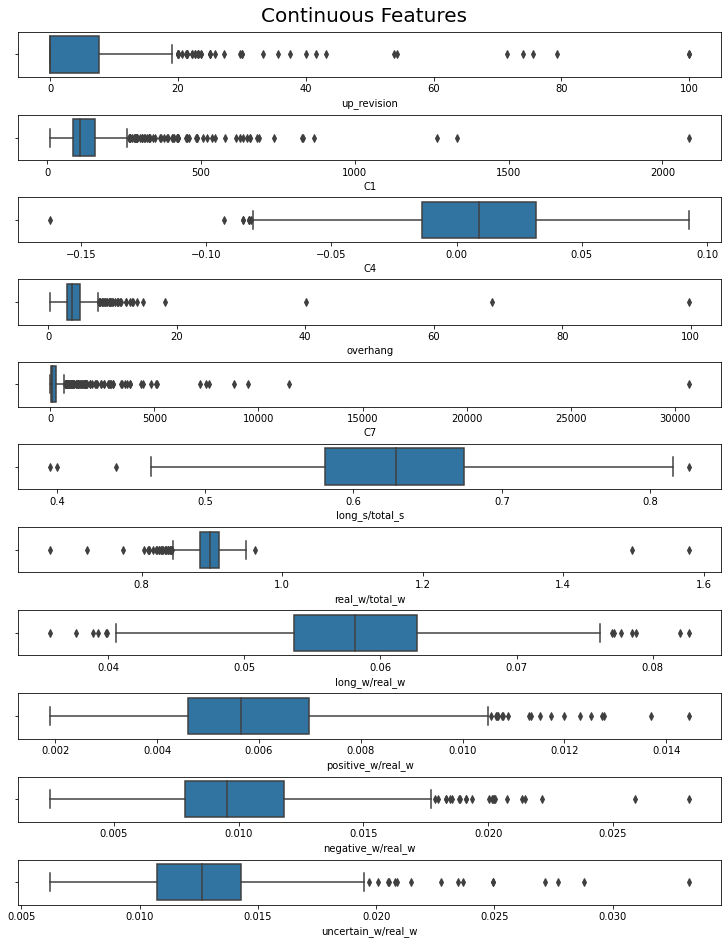

In [36]:
def eda_cont(df):
    cols = list(df.columns)
    fig, axes = plt.subplots(len(cols), 1, figsize=(10, 13), constrained_layout=True)

    for ax, feat in enumerate(cols):
        sns.boxplot(data=df, x=feat, ax=axes[ax])

    fig.suptitle("Continuous Features", fontsize=20)
    plt.show()

eda_cont(df_cont)

The boxplots among all features are unevenly distributed and need to be transformed. Some of the features have a strong skewness which will be corrected later.

We also investgiated look at the correlation among the continuous features. The correlation matrix is visualized using a heatmap. 

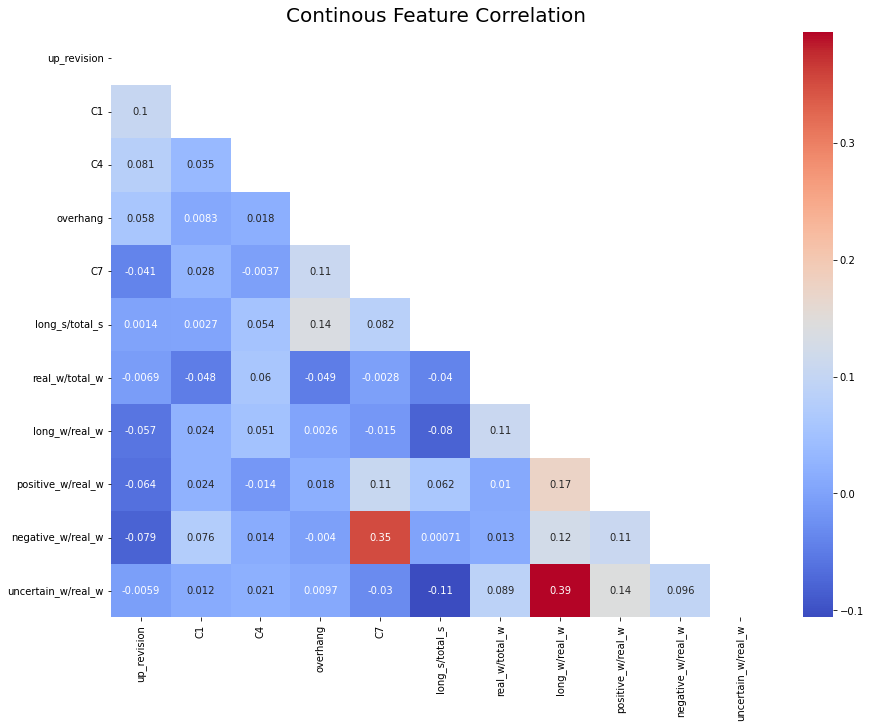

In [37]:
def heatmap(df):
    fig, axes = plt.subplots(figsize=(12,10), constrained_layout=True)

    mask = np.triu(np.ones_like(df.corr(), dtype=bool))

    sns.heatmap(data=df.corr(), mask=mask, annot=True, ax=axes, cmap = 'coolwarm')

    fig.suptitle("Continous Feature Correlation", fontsize=20)
    plt.show()

heatmap(df_cont)

Number of negative words / number of real words and C7 (sales) are having strong positive correlation. Number of uncertain words / number of real words and number of long words / number of real words are having strong positive correlation. Number of long sentences / total sentences and number of uncertain words / number of real words are having strong negative correlation. The rest of the features do not show strong correlation. 

## Categorical Features

We investigated the distribution of our categorical features using bar graphs.

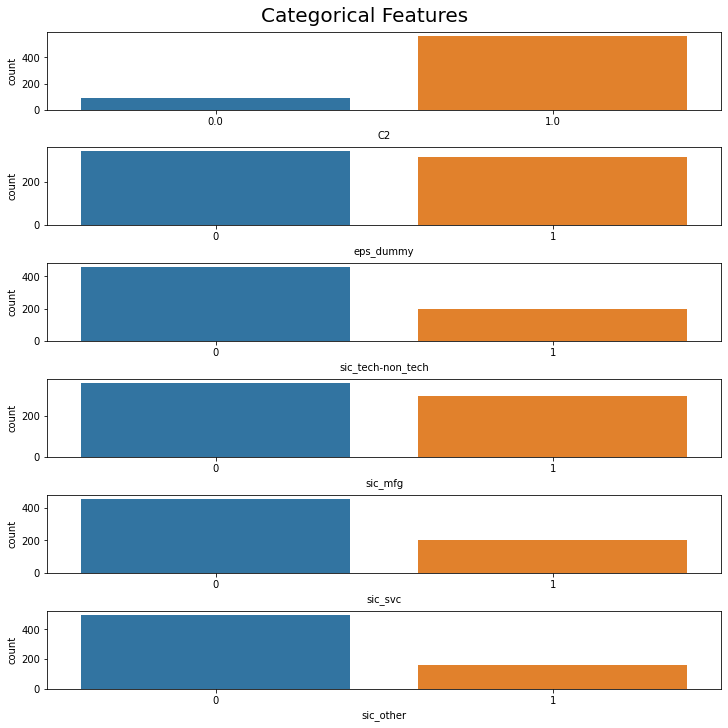

In [38]:
def eda_cat(df):
    cols = list(df.columns)
    fig, axes = plt.subplots(len(cols), 1, figsize=(10,10), constrained_layout=True)

    for ax, feat in enumerate(cols):
        sns.countplot(x=feat, data=df, ax=axes[ax])

    fig.suptitle("Categorical Features", fontsize=20)
    plt.show()

eda_cat(df_cat.iloc[:, :-2])

Most of the categorical features were evenly distributed with the exception of C2 (Top tier dummy) and the SIC codes. C2 has a low number of 0's compared to a large number of 1's which indicates that a large number of leading underwriter of IPO has a rating of 8 or higher. Features: sic_tech-non_tech, sic_svc, and sic_other all have more 0's than 1's. sic_mfg and eps_dummy features are evenly distributed among binary values. 

## Targets

Next, we look at the Y1 (Pre-IPO Price Revision) and Y2 (Post-IPO Initial Return) targets.

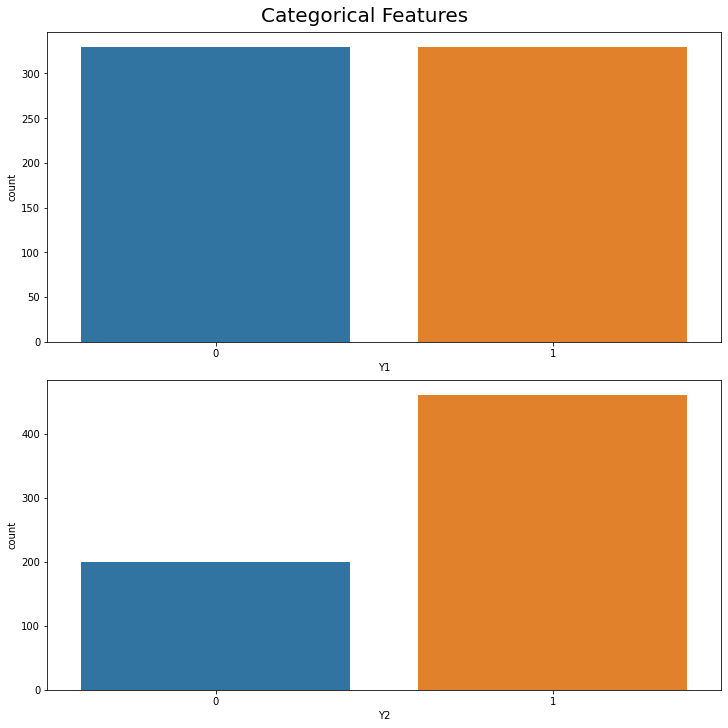

In [39]:
eda_cat(df_cat.iloc[:, -2:])

Target Y1 is evenly distributed among binary values. Target Y2 is unevenly distributed having a greater number of 1's than 0's indicating that most P(IPO) < P(1Day). Balancing of Y2 has been handled in the evaluation model that is used.

# Transformations

Now we are ready to do some transformations. We followed Process 3 and started with scaling using min-max followed by normalization using yeo-johnson and finally outlier handling using the 6 sigma method.

## Scaling

We use min-max scaling on the continues features. This method rescales the range of features within the range of 0 to 1.

In [40]:
def scale(df, method):
    names = list(df.columns)
    
    if method == 'z':
        scaler = StandardScaler()
    
    elif method == 'min-max':
        scaler = MinMaxScaler()
    
    df = pd.DataFrame(scaler.fit_transform(df), columns=names)

    return df

df_cont = scale(df_cont, 'min-max')

Now we check the distribution of these features after the scaling method is applied. Boxplots for each feature is used to show the ditribution. 

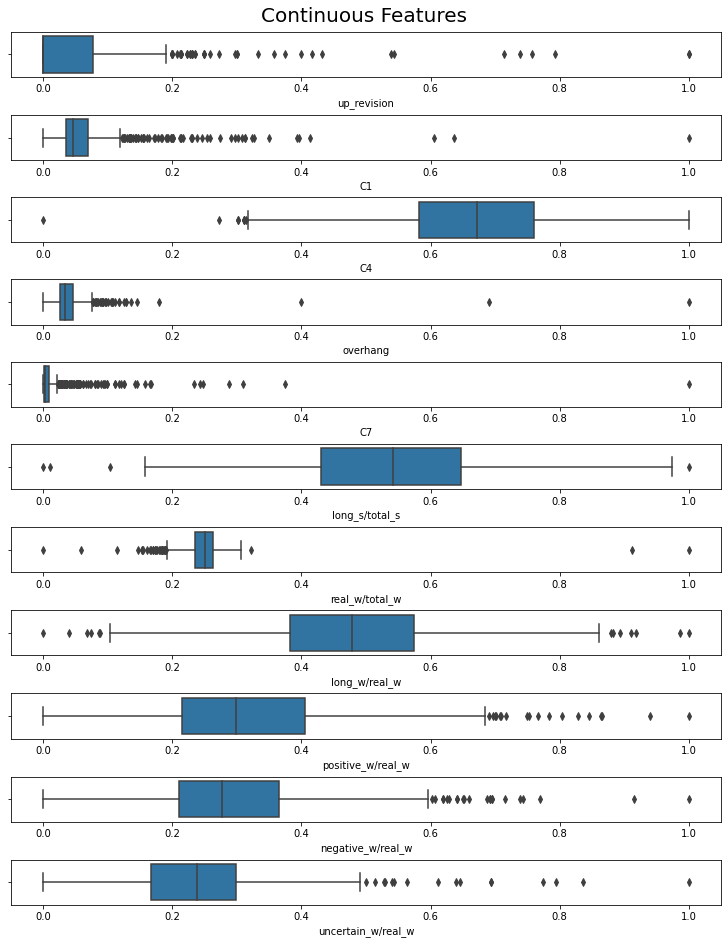

In [41]:
eda_cont(df_cont)

The scaling successfully changed the values in each distribution to be between 0 and 1.

## Normalization

We then want to explore the skewness of the data before normalizing it to ensure that the residual is randomly distributed. We will list the columns that have a skewness less than -0.5 or greater than 0.5

In [42]:
list(df_cont.loc[:, (df_cont.skew() < -.5) | (df_cont.skew() > .5)].columns)

['up_revision',
 'C1',
 'overhang',
 'C7',
 'real_w/total_w',
 'positive_w/real_w',
 'negative_w/real_w',
 'uncertain_w/real_w']

It appears that all but three of the features, long_s/total_s (the ratio of long sentences to total sentences in the IPO prospectus MD&A sections), C4 (Prior Nasdaq 15-day Returns), and long_w/real_w (the ration of long words to real words in the PO prospectus MD&A sections) are skewed outside the acceptable range of -0.5 to 0.5 To correct for this, we will use yeo-johnson on the features that are skewed.

In [43]:
def normalize(df):
    df_skew = df.loc[:, (df.skew() < -.5) | (df.skew() > .5)]
    names = list(df_skew.columns)
    pt = PowerTransformer()
    df_skew = pd.DataFrame(pt.fit_transform(df_skew), columns=names)
    df[names] = df_skew[names]
    return df

df_cont = normalize(df_cont)
df_cont.skew()

up_revision           0.719470
C1                    0.225556
C4                   -0.477892
overhang              0.137879
C7                    1.179891
long_s/total_s       -0.073343
real_w/total_w       -1.173635
long_w/real_w         0.143321
positive_w/real_w     0.000234
negative_w/real_w     0.007574
uncertain_w/real_w   -0.036707
dtype: float64

After applying yeo-johnson. Only C7 (Sales) and real_w/total_w (the ratio of real words to total words in the PO prospectus MD&A sections) features are skewed. The rest of the features are all within the threshold we previously defined.

We look at the boxplots of the same features to see how the normalization method changed their distributions.

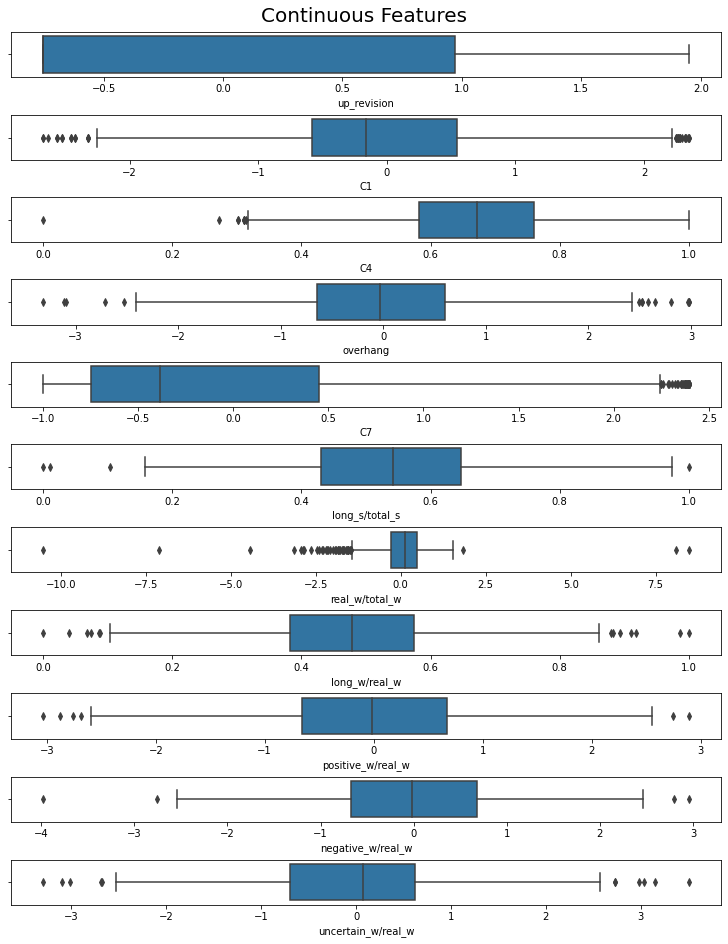

In [44]:
eda_cont(df_cont)

The median of each of the features is now closer to 0.

## Outlier Handling

To clean up the outliers in each of the features, we applied the six sigma technique. Any value less than 3 standard deviations below the mean or greater than 3 standard deviation above the mean, is classified as an outlier and replaced with the value at this threshold, the mean minus 3 standard deviations or the mean plus 3 standard deviations respectively.

In [45]:
def adjust_outliers(col1:pd.Series, method:str):
    '''
    Adjust for outliers in a series using interquartile range or 3 standard deviations
    ---
    ARGUMENTS:
    - col (Series): column from dataframe
    - method (str): adjust by interquartile range or 3 standard deviations
    ---
    OUTPUT:
    - col (Series): column with outliers adjusted for
    '''
    col = col1.copy()
    
    if method == "IQR":
        ### Calculate interquartile range
        q1 =  np.quantile(col, 0.25)
        q3 =  np.quantile(col, 0.75)
        iqr = q3-q1

        ### Use interquartile range to calculate lower and upper bounds
        low_bound = q1 - 1.5 * iqr
        up_bound = q3 + 1.5 * iqr
    
    elif method == "3std":
        ### Get bounds using 3 standard deviation
        low_bound = col.mean() - 3 * col.std()
        up_bound = col.mean() + 3 * col.std()
    
    else:
        return "error"

    ### Replace any low outliers with the lower bound and any high outliers with the upper bound
    col[col < low_bound] = low_bound
    col[col > up_bound] = up_bound

    return col

df_cont = df_cont.apply(adjust_outliers, method="3std")

In [46]:
df_cont.describe(include="all").T

,count,mean,std,min,25%,50%,75%,max
up_revision,660.0,5.652044e-17,1.000758,-0.753680,-0.753680,-0.753680,0.971692,1.950607
C1,660.0,4.252491e-16,1.000758,-2.674326,-0.584302,-0.164982,0.546955,2.349567
C4,660.0,6.650011e-01,0.128839,0.272994,0.581494,0.671804,0.759743,1.000000
overhang,660.0,7.885041e-04,0.998294,-3.002275,-0.647255,-0.031572,0.600960,2.979262
C7,660.0,6.997769e-17,1.000758,-0.999639,-0.748179,-0.385687,0.449884,2.395470
long_s/total_s,660.0,5.409598e-01,0.161061,0.056157,0.429891,0.541654,0.647486,1.000000
real_w/total_w,660.0,4.003851e-03,0.765132,-3.002275,-0.281796,0.135723,0.491741,3.002275
long_w/real_w,660.0,4.817321e-01,0.151653,0.024971,0.381868,0.477768,0.573791,0.938747
positive_w/real_w,660.0,5.018167e-05,1.000607,-3.002275,-0.662712,-0.019631,0.673828,2.893014
negative_w/real_w,660.0,1.482500e-03,0.995564,-3.002275,-0.672175,-0.012611,0.685489,2.956630


Once again we look at the distribution after outlier handling for these features. 

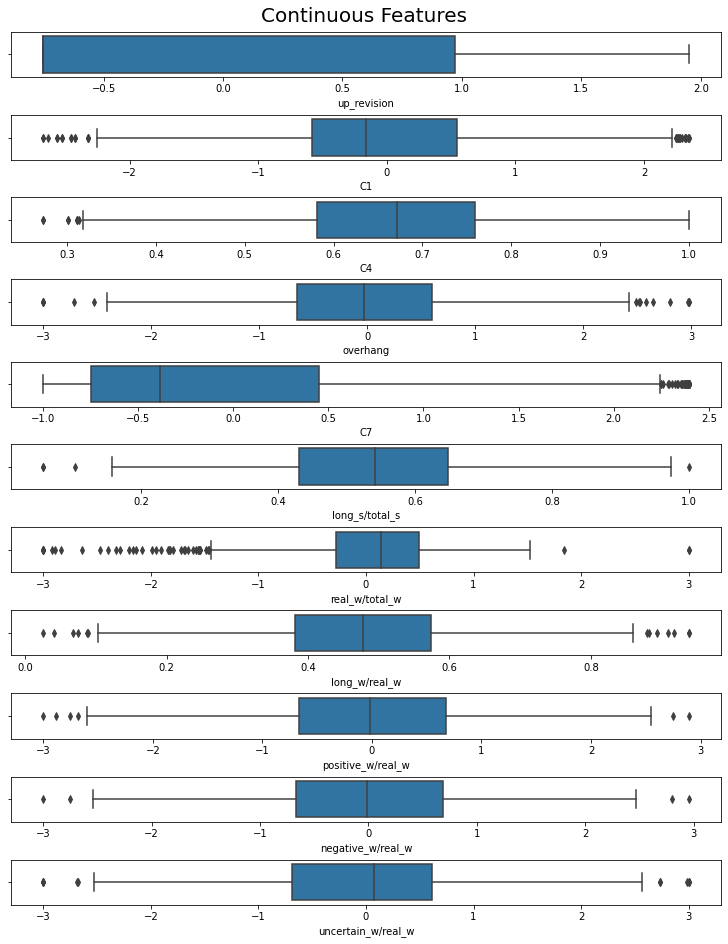

In [47]:
eda_cont(df_cont)

That looks much better! Only C7 (sales) is right skewed. 

# Final Dataset

The last step of the pre-processing stage is to combine the continuous and categorical features to get the final preprocessed dataframe which will be used for our feature selection.

In [48]:
df5 = pd.concat([df_cont, df_cat], axis=1).reset_index(drop=True)

# Feature Selection

Now for the feature selection section this took a fair amount of analysis, and trying a number of different things like varying the number of features used and which features were used to lower the F1 bias and variance as well as and the ROC bias and variance. We tried using 6, 7, and 8 features when predicting Y1 and Y2. The feature selection code returned features which we then texted with the evaluation code.

To predict Y1, 8 features were chosen: 
* C1 - Days between the initial filing and the final filing
* Overhang - The outstanding shares voer the offered shares
* C7 - The trailing sales
* long_s/total_s - The ration of long sentences to total sentences in the IPO prospectus MD&A sections
* real_w/total_w column - the ration of real words to total words in the in the IPO prospectus MD&A sections
* long_w/real_w - the ration of long words to real words in the IPO prospectus MD&A sections
* positive_w/real_w - the ration of positive words to real words in the IPO prospectus MD&A sections
* negative_w/real_w - the ratio of negative words to real words in the IPO prospectus MD&A sections

We chose to select negative_w/real_w instead of C4 to see if the correlation between positive_w/real_w and negative_w/real_w. This improved our score from the features that the feature selection code selected.

To predict Y2, 6 features were chosen.
* Up_revision - the initial IPO price minus the mid price divided by the mid price
* C4 - the NASQDAQ returns over the last 15 days
* Overhang - The outstanding shares voer the offered shares
* negative_w/real_w - The ratio of negative words to real words in the IPO prospectus MD&A sections
* uncertain_w/real_w - the ration of uncertain words to real words in the 
* sic_svc - A binary value which is 1 if the company's SIC code falls in the service category or a 0 if it does not

The only overlaping features we selected between predicting the two targets was the ratio of negative words to real words in the IPO prospectus MD&A sections and the overhang.

In [49]:
array = df5.values
names = list(df5.columns)

In [50]:
### features, targets, model

def feature_selector(X, y, model, names, _method="topk", n=0, fit_X=False, thres = 0.1):
  """voting based feature selector
  - _method: "topk" for top-K method (default), "cutoff" for cut-off based method
  - n: number of features to be selected. only available for top-K method - default half of the total features
  - thres: cut-off threshold (default 0.1), only availabel for cutoff method
  - fit_X: fit_transform X or just return indices
  TODO: include support for regression problems
  """
  #### Placeholder for tests
  # X.shape[0] == y.shape[0]
  if n == 0:
    n = int(X.shape[1]/2)

  if names: # if given feature names
    feature_names = np.array(names)
  else: # otherwise use location
    feature_names = np.array(["X%s" % x for x in range(len(X.shape[0]))])
  if _method == 'topk':
    #### np.argpartition gets the indices of the largest n element from the array in ascending order
    #### [::-1] reverse the order
    ############################################################################
    #### IMPORTANT: 
    #### use `chi2` as the `score_func` when doing categorical features - values has to be non-negative
    #### use `f_classif` as the `score_func` when doing categorical and continuous feautures
    #### use `f_regression` as the `score_func` when doing continuous feautures
    ############################################################################
    corr_features = list(np.argpartition(SelectKBest().fit(X,y).scores_, -n)[-n:][::-1])
    #### binary masking on features, use np.where() to get the indices of selected
    rfe_features = list(np.where(RFE(model, n_features_to_select=n, step=1).fit(X, y).support_)[0])
    #### argsort get sorted indices by values, ::-1] reverse the asceding order
    ridge_features = list(np.argsort(Ridge(alpha=1.0).fit(X, y).coef_)[-n:][::-1])
    #### using ExtraTree
    extratree_features = list(np.argsort(ExtraTreesClassifier().fit(X, y).feature_importances_)[-n:][::-1])
    ### using Random Forest:
    rf_features = list(np.argsort(RandomForestClassifier().fit(X, y).feature_importances_)[-n:][::-1])
    print("Using the Top-K method: ")
    print("Selected features by correlation: ", feature_names[corr_features])
    print("Selected features by RFE: ", feature_names[rfe_features])
    print("Selected features by Ridge coefficients: ", feature_names[ridge_features])
    print("Selected features by Extra Tree feature importance: ", feature_names[extratree_features])
    print("Selected features by Random Forest feature importance: ", feature_names[rf_features])

  elif _method == 'cutoff':
    corr_features, rfe_features = list(), list() #### N/A
    ridge_features = list(np.where(Ridge(alpha=1.0).fit(X, y).coef_ > thres)[0])
    extratree_features = list(np.where(ExtraTreesClassifier().fit(X, y).feature_importances_ > thres)[0])
    rf_features = list(np.where(RandomForestClassifier().fit(X, y).feature_importances_ > thres)[0])
    print("Using the Cutoff method: ")
    # print("Selected features by correlation: ", feature_names[corr_features])
    # print("Selected features by RFE: ", feature_names[rfe_features])
    print("Selected features by Ridge coefficients: ", feature_names[ridge_features])
    print("Selected features by Extra Tree feature importance: ", feature_names[extratree_features])
    print("Selected features by Random Forest feature importance: ", feature_names[rf_features])
  else:
    return("Only Top-K and Cutoff methods are currently supported!")

  ######################################
  #### combine results using voting ####
  ######################################
  counted = Counter(np.concatenate((corr_features, rfe_features, ridge_features, extratree_features, rf_features), axis=None)).most_common(n)

  #### list of tuples (feature_index, votes)
  counted.sort(key = lambda x: x[1], reverse=True)
  final_select_series = pd.Series({feature_names[f]:c for f,c in counted}).sort_values(ascending=False)
  selected_idx = sorted([f for f,c in counted])
  assert len(selected_idx) == n
  print(final_select_series)
  if fit_X:
    return(X[:, selected_idx])
  else:
    return(feature_names[selected_idx])

In [51]:
### For Y1
X1 = array[:, 1:16]
y1 = array[:, -2]
y1_selected_features = feature_selector(X1, y1, model=RandomForestClassifier(), names=names, n=8)

### For Y2
X2 = array[:, :16]
y2 = array[:, -1]
y2_selected_features = feature_selector(X2, y2, model=RandomForestClassifier(), names=names, n=6)

Using the Top-K method: 
Selected features by correlation:  ['long_w/real_w' 'real_w/total_w' 'eps_dummy' 'C2' 'C1' 'long_s/total_s'
 'positive_w/real_w' 'C7']
Selected features by RFE:  ['C1' 'C4' 'overhang' 'C7' 'long_s/total_s' 'real_w/total_w'
 'positive_w/real_w' 'negative_w/real_w']
Selected features by Ridge coefficients:  ['C7' 'real_w/total_w' 'long_s/total_s' 'positive_w/real_w' 'sic_mfg'
 'sic_tech-non_tech' 'up_revision' 'long_w/real_w']
Selected features by Extra Tree feature importance:  ['positive_w/real_w' 'long_w/real_w' 'long_s/total_s' 'real_w/total_w'
 'C1' 'overhang' 'C7' 'C4']
Selected features by Random Forest feature importance:  ['positive_w/real_w' 'real_w/total_w' 'long_s/total_s' 'overhang' 'C1'
 'C7' 'long_w/real_w' 'C4']
real_w/total_w       5
long_s/total_s       5
positive_w/real_w    5
C7                   5
long_w/real_w        4
C1                   4
C4                   3
overhang             3
dtype: int64
Using the Top-K method: 
Selected features

Finally, we created two dataframes each containg the features we selected to predict the target, and the target we were predicting.

In [52]:
### Features selected when predicting Y1
### ['C1', 'overhang', 'C7', 'long_s/total_s', 'real_w/total_w', 'long_w/real_w', 'positive_w/real_w', 'negative_w/real_w']
df_y1 = df5.loc[:, ('C1', 'overhang', 'C7', 'long_s/total_s', 'real_w/total_w', 'long_w/real_w', 'positive_w/real_w', 'negative_w/real_w')]
df_y1['Y1'] = df5['Y1']
df_y1.to_csv('/content/drive/MyDrive/Colab Notebooks/data/group_5-Y1.csv')

### Features selected when predicting Y2
### ['up_revision', 'C4', 'overhang', 'negative_w/real_w', 'uncertain_w/real_w', 'sic_svc']
df_y2 = df5.loc[:, ('up_revision', 'C4', 'overhang', 'negative_w/real_w', 'uncertain_w/real_w', 'sic_svc')]
df_y2['Y2'] = df5['Y2']
df_y2.to_csv('/content/drive/MyDrive/Colab Notebooks/data/group_5-Y2.csv')